# 4.2 Multi Layer Perceptrons

The linear model cannot fit all of the data. We can introduce nonlinearity by including hidden layers that connect each neuron with each other.

![Multi Layer Perceptron](../img/mlps.svg)
A MLP with a fully connected hidden layer. It has 4 inputs, 3 outputs, 5 hidden units.

MLPs can capture complex interactions among our inputs via their hidden neurons, which depend on the values of each of the inputs. We can model any function, so they are great universal approximators.

A **fully connected** or **dense** layer is one where all neurons are connected to all neurons from the previous layer. The output of a fully connected layer is:
$h(\mathbf{x}) = \phi (\mathbf{W} \mathbf{x} + \mathbf{b})$,

where $\phi()$ is the activation function, $\mathbf{b}$ is the bias vector, $\mathbf{W}$ is the weight vectors, $\mathbf{x}$ is the feature vector. Training a MLP is finding the weights and biases that best


## 1. Activation Functions
Activation functions decide whether a neuron should be activated or not by calculating the weighted sum and further adding bias with it. We will review the activation functions: 
* **Rectified linear unit (ReLU)**
ReLU provides a very simple nonlinear transformation. 
$ReLU(x)=max(x,0).$
The reason for using ReLU is that its derivatives are particularly well behaved: either they vanish or they just let the argument through. This makes optimization better behaved. These are the most popular activation functions, easier to implement and to train.
* **Sigmoid Function**
The sigmoid function transforms its inputs, for which values lie in the real domain, to outputs that lie on the interval (0, 1). 
$\sigma(x) = \frac{1}{1+\exp(-x)}$ 
The sigmoid function is a smooth, "S-shaped", differentiable approximation to a thresholding unit. Sigmoids are still widely used as activation functions on the output units, when we want to interpret the outputs as probabilities for binary classification problems.

* **Tanh Function**
The hyperbolic tangent function is happy middle between the sigmoid and the ReLU as it is slightly more linear near zero.
$\tanh(x) = 2 \sigma(2x) -1$
Tanh is also "S-shaped"

Text(0.5, 1.0, 'activation functions')

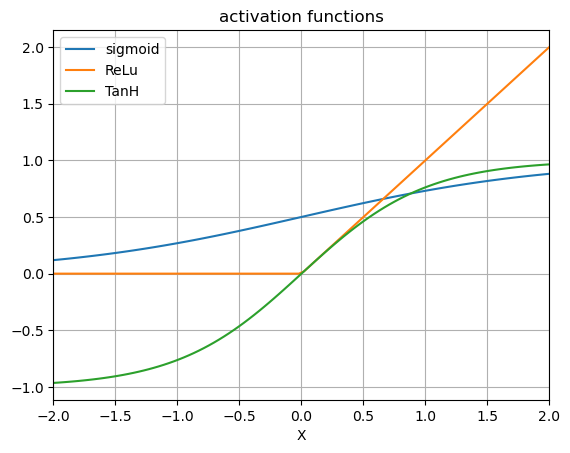

In [48]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
x=np.linspace(-2,2,100)

def sigm(x): # define the sigmoid function
    return 1/(1+np.exp(-x))
def relu(x): # define the Rectified Linear Unit function
    return   np.maximum(x,0)


s = sigm(x)
t = np.tanh(x)
r = relu(x)

plt.plot(x,s)
plt.plot(x,r)
plt.plot(x,t)
plt.grid(True)
plt.legend(['sigmoid','ReLu','TanH'])
plt.xlim([-2,2])
plt.xlabel('X')
plt.title('activation functions')

## 2. Typical MLP structures


A **Regression MLP** outputs scalar values, the number of output neurons is the number of values and the number of the output dimensions. For instance, to output a 2D geospatial coordinates on a map, you may need to output 2 values in 2 output neurons: latitudes and longitudes. For any real scalar as output values, the output layer is a normal layer of neurons. To constrain the value of the outputs, you can add an activation function in the output layer: use a *ReLU* or a *softplus* function for **strictly positive** values and a *sigmoid* or *tanh* activation function for **bounded values** between 0 (or -1) to 1 by scaling the output. A simple representation of a regression MLP is show in the first figure. 


![Regression MLP](../img/MLPReg.png)


A **Classification MLP** outputs the probability of the positive class, a scalar value between 0 and 1. Use a *ReLU* or a *softplus* as an activation function in the output layer.

![Classification MLP](../img/MLPClass.png)

## 3. Training Neural Networks

Training starts by handling a smaller batch of data inputs. 

The *forward pass* sends the mini-batch from the input layer to the hidden layers. *Forward propagation* sequentially calculates and stores intermediate variables within the computational graph defined by the neural network. It proceeds from the input to the output layer and makes prediction.

Next, the algorithm measures the error using a loss function and calculate how much each of the output connection contributed to the error.

*Backpropagation* sequentially calculates and stores the gradients of intermediate variables and parameters within the neural network in the reversed order. Backpropagation is merely an application of chain rule to find the derivatives of cost with respect to any variable in the nested equation. The derivative of cost with respect to any weight in the network simply is the multiplication of the corresponding layer’s error times its input. Therefore in training, one has to save each layer input in addition to the weights, and therefore requires additional memory compared to a simple forward pass (prediction).

The algorithm then performs Gradient Descent to update the weights.

**Drop out**
One additional mitigation against overfitting is to use dropout layers during training. During training, the Dropout layer will randomly drop out outputs of the previous layer (or equivalently, the inputs to the subsequent layer) according to the specified dropout probability. Dropout is only used during training.

![Multi Layer Perceptron](../img/dropout2.svg)


a **Sequential** model is a single branch MLP. 


## 4. MLP in Pytorch

In [49]:
import torch
import torch.nn as nn
import torch.optim as optim 
import matplotlib.pyplot as plt
import os
import numpy as np

### 4.1 Prepare Data


In [50]:
# load data set in memory
from sklearn.datasets import load_digits
digits = load_digits() # load data set
data,labels = digits["data"].copy(),digits["target"].copy() # copy data and target
data = data.astype(np.float32).reshape(-1,8,8) # reshape data on 8x8 grid
print(data.shape,labels.shape)

(1797, 8, 8) (1797,)


Prepare the PyTorch-friendly data set:
1. Make ``Dataset``
2. Split train-test
3. Use ``DataLoader``

In [51]:

from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split

class CustomDataset(Dataset): # create custom dataset
    def __init__(self, data,labels): # initialize
        self.data = data 
        self.labels = labels 

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        sample_data = self.data[index]
        sample_labels = self.labels[index]
        return torch.Tensor(sample_data),(sample_labels) # return data as a tensor

custom_dataset = CustomDataset(data, labels)


# Determine the size of the training set
train_size = int(0.8 * len(custom_dataset)) # 80% of the data set
test_size = len(custom_dataset) - train_size # 20% of the data set

# Use random_split to create training and testing subsets
train_dataset, test_dataset = random_split(custom_dataset, [train_size, test_size])



# Create a DataLoader
batch_size = 32  # Adjust according to your needs
shuffle = True   # Set to True if you want to shuffle the data
data_loader_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
data_loader_test = DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle)


### 4.2 Design Model

Set a random seeed for reproducibility

In [52]:
  # Set fixed random number seed
torch.manual_seed(42)

Let's create a Classification MLP for a multi-class problem. We use a flattened input layer to turn the 2D matrix into a 1D vector. The

In [60]:
# Fully connected MLP
class my_mlp(nn.Module): # a class defines an object

    # this defines the architecture of the NN
    def __init__(self, size_img, num_classes):
        # Here we define all the functions that we will use during the forward part (data -> prediction)
        super(my_mlp, self).__init__()

        self.flatten = nn.Flatten() # go from a 8*8 tensor to a 64*1 tensor
        self.layer1 = nn.Linear(size_img * size_img, 32)
        self.relu1 = nn.ReLU()
        self.layer2 = nn.Linear(32,16)
        self.relu2 = nn.ReLU()
        self.output_layer = nn.Linear(16,num_classes)
        self.sigmoid = nn.Sigmoid()

    # this defines how the data passes through the layers
    def forward(self, x):
        # Here we explain in which order to use the functions defined above
        x = self.flatten(x)
        x = self.relu1(self.layer1(x))
        x = self.layer2(x)
        return self.sigmoid(x)

Below is the syntax if you use Keras/TensorFlow

In [54]:
# model = keras.models.Sequential( [
# keras.layers.Flatten(input_shape=[28,28]), # reshape the 2D matrix into a 1D vector, without modifying the values
# keras.layers.Dense(300,activation="relu"), # single dense layer, downsampling from input layer to this year from 784 points to 300.
# keras.layers.Dense(100,activation="relu"), # 100 neurons
# keras.layers.Dense(10,activation="softmax") ]) # output layer, 10 neurons since there are 10 classes.

In [61]:
model = my_mlp(8, 10)
print(model)

my_mlp(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layer1): Linear(in_features=64, out_features=32, bias=True)
  (relu1): ReLU()
  (layer2): Linear(in_features=32, out_features=16, bias=True)
  (relu2): ReLU()
  (output_layer): Linear(in_features=16, out_features=10, bias=True)
  (sigmoid): Sigmoid()
)


### 4.3 Optimization

Choose an optimizer to train the algorithm: https://pytorch.org/docs/stable/optim.html. Choose hyperparameters.

In [56]:
alpha = 0.005# learning rate lr
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=alpha)

### 4.4 Training

Compile the model by setting the loss function, the optimizer to use, and the metrics to use during training and evaluation

During the fitting, it may be important to save intermediate steps and maybe revert back to an earlier version of the training. For this, we will use **checkpoints** to save the model at regular intervals during the training.

In [65]:
def train(model, n_epochs, trainloader, testloader=None,learning_rate=0.001 ):

    dir0 = './my_mlp_checkpoint'
    os.makedirs(dir0,exist_ok=True) 
    
    criterion = nn.CrossEntropyLoss() # loss function

    optimizer = optim.SGD(model.parameters(), lr=learning_rate) # optimizer
    
    # Save loss and error for plotting
    loss_time = np.zeros(n_epochs)
    accuracy_time = np.zeros(n_epochs)

    # TRAIN Loop on number of epochs
    for epoch in range(n_epochs):
        # Initialize the loss
        running_loss = 0
        # Loop on samples in train set
        for data in trainloader:
            # Get the sample and modify the format for PyTorch
            inputs, labels = data[0], data[1]
            inputs = inputs.float()
            labels = labels.long()
            # Set the parameter gradients to zero
            optimizer.zero_grad() 
            outputs = model(inputs) # forward pass
            loss = criterion(outputs, labels) # compute loss
            loss.backward() # backward pass
            optimizer.step() # update weights
            running_loss += loss.item() # sumup loss
        # Save loss at the end of each epoch
        loss_time[epoch] = running_loss/len(trainloader)
        # note that here the loss is the average loss per sample over the batch
        
        checkpoint = {
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict()
                        }
        
        f_path = dir0+'/checkpoint.pt'
        torch.save(checkpoint, f_path)
        

        
        # TEST: After each epoch, evaluate the performance on the test set
        if testloader is not None:
            correct = 0
            total = 0
            # We evaluate the model, so we do not need the gradient
            with torch.no_grad(): # Context-manager that disabled gradient calculation.
                # Loop on samples in test set
                for data in testloader:
                    # Get the sample and modify the format for PyTorch
                    inputs, labels = data[0], data[1]
                    inputs = inputs.float() 
                    labels = labels.long()
                    # Use model for sample in the test set
                    outputs = model(inputs)
                    # Compare predicted label and true label
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
            # Save error at the end of each epochs
            accuracy_time[epoch] = 100 * correct / total
    
        # Print intermediate results on screen
        if testloader is not None:
            print('[Epoch %d] loss: %.3f - accuracy: %.3f' %
              (epoch + 1, running_loss/len(trainloader), 100 * correct / total))
        else:
            print('[Epoch %d] loss: %.3f' %
              (epoch + 1, running_loss/len(trainloader)))

    # Save history of loss and test error
    if testloader is not None:
        return (loss_time, accuracy_time)
    else:
        return (loss_time)

Train the model

In [68]:
(loss, accuracy) = train(model, 200, data_loader_train, data_loader_test, alpha)

[Epoch 1] loss: 1.914 - accuracy: 95.833
[Epoch 2] loss: 1.914 - accuracy: 96.111
[Epoch 3] loss: 1.914 - accuracy: 95.556
[Epoch 4] loss: 1.914 - accuracy: 95.833
[Epoch 5] loss: 1.913 - accuracy: 96.111
[Epoch 6] loss: 1.913 - accuracy: 95.556
[Epoch 7] loss: 1.913 - accuracy: 96.111
[Epoch 8] loss: 1.913 - accuracy: 95.556
[Epoch 9] loss: 1.913 - accuracy: 96.111
[Epoch 10] loss: 1.913 - accuracy: 96.111
[Epoch 11] loss: 1.913 - accuracy: 96.111
[Epoch 12] loss: 1.913 - accuracy: 96.111
[Epoch 13] loss: 1.912 - accuracy: 96.111
[Epoch 14] loss: 1.912 - accuracy: 95.833
[Epoch 15] loss: 1.912 - accuracy: 96.111
[Epoch 16] loss: 1.912 - accuracy: 96.111
[Epoch 17] loss: 1.912 - accuracy: 96.111
[Epoch 18] loss: 1.912 - accuracy: 96.111
[Epoch 19] loss: 1.912 - accuracy: 96.111
[Epoch 20] loss: 1.912 - accuracy: 95.833
[Epoch 21] loss: 1.912 - accuracy: 96.389
[Epoch 22] loss: 1.911 - accuracy: 96.111
[Epoch 23] loss: 1.911 - accuracy: 96.111
[Epoch 24] loss: 1.911 - accuracy: 96.389
[

Plot the learning curve

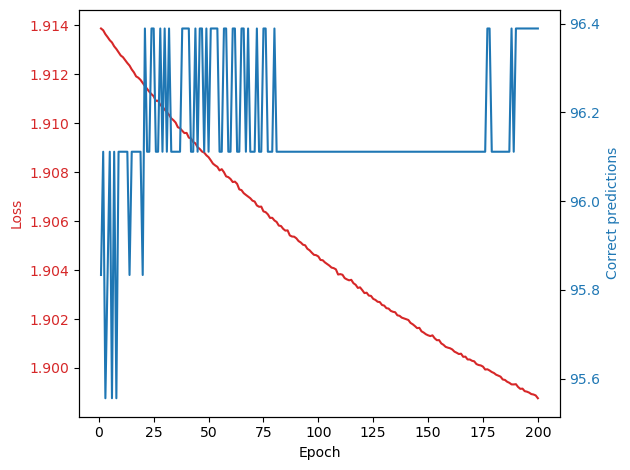

In [69]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
ax1.plot(np.arange(1, len(loss)+1), loss, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Correct predictions', color=color)
ax2.plot(np.arange(1, len(accuracy)+1), accuracy, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()

Report value on test set.

In [ ]:
X_new = X_test[:2]
y_proba = model.predict(X_new).round(2)
print(y_proba)

NameError: name 'X_test' is not defined

## 4. Saving and restoring a model

## 5. Fine-tuning of Neural Networks Hyperparameters

Trial and error is a great first step to build some basic intuition around NN and their training. However, a more systematic approach is to search the hyper-parameter space using grid search or randomized searches. 
Scikit-learn has modules dedicated to this: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html

We will need to bundle our keras-built model into a function callable by scikit-learn. This is done using the ``KerasRegressor`` and ``KerasClassifer`` objects.
More on this later!

### MLP with scikit learn
There are some basic NN built in scikit learn, you can see below a tutorial. However, it is limited and one would use pytorch, keras, or tensorflow for any moderate to large model training. Here we will use a "sparse" categorical cross entropy. Cross entropy is used in multiclass classification. Categorical is because the classes are exclusive and that we have sparse labels (either 0 or 1).

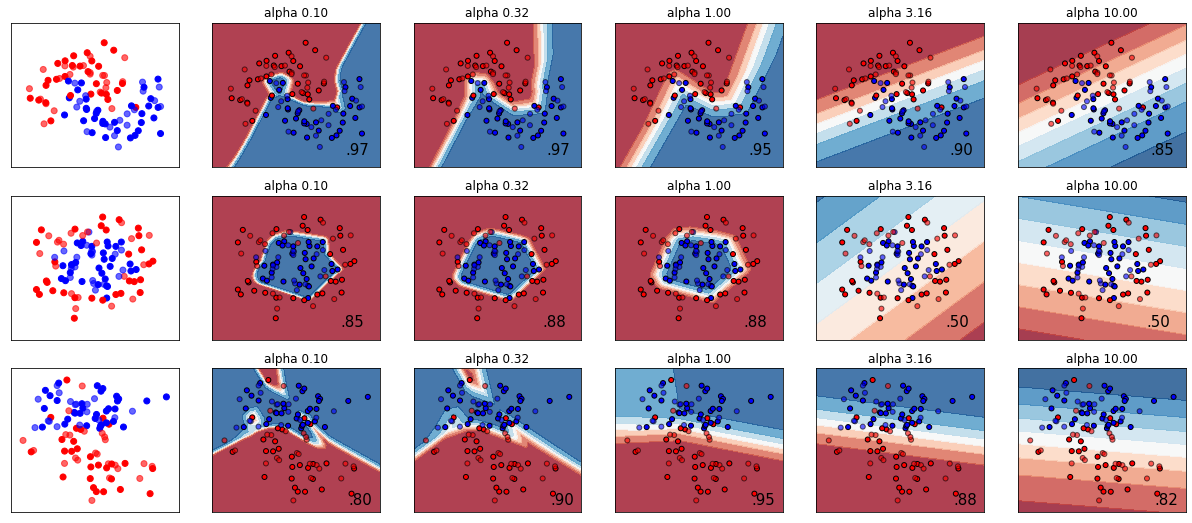

In [ ]:
# Below is an exampled of a classification MLP using Scikit learn.
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline

h = .02  # step size in the mesh
alphas = np.logspace(-1, 1, 5)

classifiers = []
names = []
for alpha in alphas:
    classifiers.append(make_pipeline(
        StandardScaler(),
        MLPClassifier(
            solver='lbfgs', alpha=alpha, random_state=1, max_iter=2000,
            early_stopping=True, hidden_layer_sizes=[100, 100],
        )
    ))
    names.append(f"alpha {alpha:.2f}")

X, y = make_classification(n_features=2, n_redundant=0, n_informative=2,
                           random_state=0, n_clusters_per_class=1)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [make_moons(noise=0.3, random_state=0),
            make_circles(noise=0.2, factor=0.5, random_state=1),
            linearly_separable]

figure = plt.figure(figsize=(17, 9))
i = 1
# iterate over datasets
for X, y in datasets:
    # split into training and test part
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4)

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright)
    # and testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)

        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max] x [y_min, y_max].
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

        # Plot also the training points
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
                   edgecolors='black', s=25)
        # and testing points
        ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
                   alpha=0.6, edgecolors='black', s=25)

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        ax.set_title(name)
        ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
                size=15, horizontalalignment='right')
        i += 1

figure.subplots_adjust(left=.02, right=.98)
plt.show()

### Forward Model with PyTorch

Scikit-learn is usually referred for tree-based models (e.g., random forest, xgboost,). PyTorch and Tensorflow are more powerful regarding neural network type of models. Here is a simple example of PyTorch creating a model for this task. 

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # 5*5 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square, you can specify with a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
print(net)

: 